# 한영 번역기 만들기

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

from konlpy.tag import Mecab

from tqdm import tqdm
import random
import time
import html
import re
import os
import io

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# Step 1. 데이터 다운로드

In [3]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.test.tar.gz

!tar -xvf korean-english-park.train.tar.gz
!tar -xvf korean-english-park.test.tar.gz

--2023-08-24 12:02:42--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2023-08-24 12:02:42--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean

In [4]:
!ls

12.ipynb			 korean-english-park.train.en
korean-english-park.test.en	 korean-english-park.train.ko
korean-english-park.test.ko	 korean-english-park.train.tar.gz
korean-english-park.test.tar.gz  README.md


In [5]:
kor_corpus = []
with open('korean-english-park.train.ko', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        kor_corpus.append(line)

print('총' + str(len(kor_corpus)) + '줄의 한국어 문장 로드 완료')

총94123줄의 한국어 문장 로드 완료


In [6]:
eng_corpus = []
with open('korean-english-park.train.en', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        eng_corpus.append(line)

print('총' + str(len(eng_corpus)) + '줄의 영어 문장 로드 완료')

총94123줄의 영어 문장 로드 완료


In [7]:
for i, (kor, eng) in enumerate(zip(kor_corpus, eng_corpus)):
    if i == 10:
        break
    print('한국어:', kor)
    print('영어 :', eng)

한국어: 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"

영어 : Much of personal computing is about "can you top this?"

한국어: 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.

영어 : so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

한국어: 그러나 이것은 또한 책상도 필요로 하지 않는다.

영어 : Like all optical mice, But it also doesn't need a desk.

한국어: 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.

영어 : uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

한국어: 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.

영어 : Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.

한국어: 이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러)

In [8]:
for kor, eng in zip(kor_corpus, eng_corpus):
    if '유시프의' in kor:
        print(kor)
        print(eng)

유시프의 어머니인 자이네브는 이에 대해 “당연하다”고 답변했다.

The reply: "Of course," said Youssif's mother, Zainab.

이 재단에서 유시프 가족의 여행비용과 유시프의 치료비 전액을 부담하게 된다.

For the first time in a long time, the family laughed out of pure joy. See Youssif play with his new toys &raquo;

CNN은 TV와 온라인을 통해 지난달 22일 유시프의 안타까운 사연을 보도했다.

Standing on the apartment's balcony, Youssif's father turned to Barbara Friedman, executive director of the Children's Burn Foundation.

유시프의 가족은 아이의 치료를 위해 외국으로 떠날지 아니면 이라크에 남을지 결정을 내려야 했다.

Specifically, the family had to make a decision on whether to leave their homeland or stay inside Iraq for treatment.

그러나 가족은 유시프의 장래를 위해 미국행을 고려할 수 밖에 없었다.

But the family has decided Youssif should seek treatment in the United States.

유시프의 아버지는 아들의 미국행이 결정됐다는 소식에 “행복한 마음으로 비행기에 오를 수 있을 것 같다”며 희망 섞인 발언을 했다.

Youssif's father was also cheered by the news.



원본 파일의 한국어와 영어 문장 쌍이 잘 맞지 않는 것으로 보아 모델의 학습 결과가 낮을 것으로 예상

# Step 2. 데이터 정제

## 중복 데이터 제거

In [9]:
cleaned_corpus = list(set(zip(kor_corpus, eng_corpus)))
print("중복 데이터를 전부 제거한 후 샘플 수:", len(cleaned_corpus))

중복 데이터를 전부 제거한 후 샘플 수: 78968


In [10]:
kor_corpus = []
eng_corpus = []

# 한국어와 영어 문장을 다시 분리
for kor, eng in cleaned_corpus:
    # 학습 속도를 위해 40 단어를 초과하는 문장 제거
    if len(kor.split()) > 40 or len(eng.split()) > 40:
        continue
        
    kor_corpus.append(kor)
    eng_corpus.append(eng)
    
print('한국어 문장:', len(kor_corpus))
print('영어 문장:', len(eng_corpus))

한국어 문장: 75577
영어 문장: 75577


## 텍스트 전처리 
- 영어 소문자화
- html 엔티티 제거
    - html 엔티티를 특수문자로 인코딩
- 문장부호 단일 토큰화
- 긴 공백 줄이기
- 한글, 영문자, 숫자, 문장부호를 제외한 모든 글자 제거

In [11]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip() # 영어 소문자화
    sentence = html.unescape(sentence)  # html 엔티티 인코딩

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 문장부호 분리
    sentence = re.sub(r'[" "]+', " ", sentence)       # 긴 공백 줄이기
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z0-9?.!,]+", " ", sentence) # 불필요한 글자 제거

    sentence = sentence.strip() # 문장의 양쪽 공백 제거

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'

    return sentence

In [12]:
kor_sentences = list(map(preprocess_sentence, kor_corpus))
eng_sentences = list(map(lambda s: preprocess_sentence(s, s_token=True, e_token=True), 
                                  eng_corpus))

for i, (kor, kor_pre, eng, eng_pre) in enumerate(zip(kor_corpus, 
                                                     kor_sentences, 
                                                     eng_corpus,
                                                     eng_sentences)):
    if i == 10:
        break
    print('전처리 전 한국어:', kor)
    print('전처리 후 한국어:', kor_pre)
    
    print('전처리 전 영어 :', eng)
    print('전처리 후 영어 :', eng_pre)
    print('-'*80)

전처리 전 한국어: 팝 스타 빌리조엘이 얼마전 반전 메시지가 담긴 싱글 앨범 ‘크리스마스 인 팔루자(Chrismas in Fallujah)’를 발표했다.

전처리 후 한국어: 팝 스타 빌리조엘이 얼마전 반전 메시지가 담긴 싱글 앨범 크리스마스 인 팔루자 chrismas in fallujah 를 발표했다 .
전처리 전 영어 : NEW YORK (CNN) Billy Joel has released a new pop single, the anti-war "Christmas in Fallujah.

전처리 후 영어 : <start> new york cnn billy joel has released a new pop single , the anti war christmas in fallujah . <end>
--------------------------------------------------------------------------------
전처리 전 한국어: advocate 지지자, 옹호자, 대변인

전처리 후 한국어: advocate 지지자 , 옹호자 , 대변인
전처리 전 영어 : “ Jon, the President summoned 120 experts - from doctors and patients' advocates to executives of drug and insurance companies, even some who helped kill the Clinton health plan.

전처리 후 영어 : <start> jon , the president summoned 120 experts from doctors and patients advocates to executives of drug and insurance companies , even some who helped kill the clinton health plan . <end>
-----------------------------------------------------------

# Step 3. 데이터 토큰화
## 한국어 문장

In [13]:
kor_spliter = Mecab()
kor_splited = []
for sentence in kor_sentences:
    kor_splited.append(kor_spliter.morphs(sentence))

In [14]:
vocab_size = 30000

kor_tokenizer = keras.preprocessing.text.Tokenizer(
    num_words=vocab_size,
)

kor_tokenizer.fit_on_texts(kor_splited)
kor_tensor = kor_tokenizer.texts_to_sequences(kor_splited)
kor_sequences = keras.preprocessing.sequence.pad_sequences(kor_tensor, maxlen=85, padding='post')

In [15]:
kor_sequences[0]

array([ 3743,   796,     3,  1614,    49,  4370,  1013,    15,  2471,
        6340,  2089,  1700,    23,   678,  8896,   529, 20140,     9,
         113,    11,     2,     1,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [16]:
print(kor_tokenizer.sequences_to_texts(kor_sequences[0:1]))

['팝 스타 이 얼마 전 반전 메시지 가 담긴 싱글 앨범 크리스마스 인 팔 루자 in fallujah 를 발표 했 다 .']


## 영어 문장

In [17]:
eng_splited = [eng.split() for eng in eng_sentences]

In [18]:
eng_tokenizer = keras.preprocessing.text.Tokenizer(
    num_words=vocab_size,
)

eng_tokenizer.fit_on_texts(eng_splited)
eng_tensor = eng_tokenizer.texts_to_sequences(eng_splited)
eng_sequences = keras.preprocessing.sequence.pad_sequences(eng_tensor, maxlen=59, padding='post')

In [19]:
eng_sequences[0]

array([    4,    49,   230,    65,  7254,  7836,    25,   313,     8,
          49,  2740,  1247,     3,     1,   575,   173,  1635,     9,
       13224,     2,     5,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [20]:
print(eng_tokenizer.sequences_to_texts(eng_sequences[0:1]))

['<start> new york cnn billy joel has released a new pop single , the anti war christmas in fallujah . <end>']


# Step 4. 모델 설계

In [21]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_encoder = layers.Dense(units)
        self.w_decoder = layers.Dense(units)
        self.w_combine = layers.Dense(1)

    def call(self, H_encoder, H_decoder):
        H_encoder = self.w_encoder(H_encoder)

        H_decoder = tf.expand_dims(H_decoder, axis=1)
        H_decoder = self.w_decoder(H_decoder)
        
        score = self.w_combine(tf.nn.tanh(H_encoder + H_decoder))
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * H_encoder
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [22]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embed_dim, enc_dim):
        super(Encoder, self).__init__()
        self.embedding = layers.Embedding(vocab_size, embed_dim)
        self.gru = layers.GRU(enc_dim,
                              return_sequences=True) # 어텐선 점수 계산을 위해 각 스탭별 hidden state를 반환
    
    def call(self, x):
        x = self.embedding(x)
        output = self.gru(x)
        return output

In [23]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embed_dim, dec_dim):
        super(Decoder, self).__init__()
        self.embedding = layers.Embedding(vocab_size, embed_dim)
        self.attention = BahdanauAttention(dec_dim)
        self.gru = layers.GRU(dec_dim, 
                              return_sequences=True,
                              return_state=True)
        self.fc = layers.Dense(vocab_size)
    
    def call(self, x, h_decoder, h_encoder):
        x = self.embedding(x)
        context_v, attn = self.attention(h_encoder, h_decoder)
        x = tf.concat([tf.expand_dims(context_v, axis=1), x],
                      axis=-1)
        x, h_decoder = self.gru(x)
        x = self.fc(x)
        x = tf.reshape(x, (-1, x.shape[2]))
        return x, h_decoder, attn

In [34]:
embed_dim = 128
units = 128

encoder = Encoder(vocab_size, embed_dim, units)
decoder = Decoder(vocab_size, embed_dim, units)

# Step 5: 훈련하기

In [35]:
# 옵티마이저
optimizer = keras.optimizers.Adam()

# 손실함수
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

In [36]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0] # 배치사이즈
    loss = 0

    with tf.GradientTape() as tape:
        # 인코더
        # src = tf.reverse(src, [-1])
        enc_out = encoder(src)
        h_dec = enc_out[:, -1] # 마지막 hidden state를 디코더의 첫 hidden_state로 사용

        # 디코더
        # 디코더가 생성한 시퀀스를 저장할 배열
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            # 다음 단어 예측
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            # 손실값 계산
            loss += loss_function(tgt[:, t], pred)
            # 강제 교수를 위해 디코더의 입력 시퀀스를 정답 시퀀스에서 가져옴
            dec_src = tf.expand_dims(tgt[:, t], 1)

    # 평균 손실 값 계산
    batch_loss = (loss / int(tgt.shape[1]))

    # 옵티마이저로 가중치 업데이트
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [37]:
def predict(src, encoder, decoder):
    # 입력 데이터 전처리
    src = preprocess_sentence(src)
    src = kor_spliter.morphs(src)
    src = kor_tokenizer.texts_to_sequences([src])
    src = keras.preprocessing.sequence.pad_sequences(src, maxlen=85, padding='post')
    
    # 인코더
    # src = tf.reverse(src, [-1])
    enc_out = encoder(src)
    dec_hidden = enc_out[:,-1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)
    
    output = np.zeros((59,))
    
    for t in range(59):
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out)

        # 디코더가 예측한 단어 글자화
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        # 종료 토큰 발견시 즉시 종료
        if predicted_id == 0 or eng_tokenizer.index_word[predicted_id] == '<end>':
            break
        
        dec_input = tf.expand_dims([predicted_id], 0)
        output[t] = predicted_id

    return eng_tokenizer.sequences_to_texts(output.reshape((1, -1)))[0]

In [38]:
BATCH_SIZE = 64
EPOCHS = 30
EPOCH_START = 0 # 이어서 학습할 때 사용, 중단한 epoch에서 시작

for epoch in range(EPOCHS):
    total_loss = 0

    # 데이터셋 섞기
    idx_list = list(range(0, kor_sequences.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_sequences[idx:idx+BATCH_SIZE], # batch를 직접 지정
                                eng_sequences[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (EPOCH_START + epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm
    
    # 학습한 결과 확인하기
    print('Epoch', EPOCH_START + epoch + 1, 'Result')
    for kor in ["오바마는 대통령이다.", "시민들은 도시 속에 산다.", "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]:
        print(kor)
        print('=>', predict(kor, encoder, decoder))
        print('')

Epoch  1: 100%|██████████| 1181/1181 [04:23<00:00,  4.48it/s, Loss 2.9554]


Epoch 1 Result
오바마는 대통령이다.
=> the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

시민들은 도시 속에 산다.
=> the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

커피는 필요 없다.
=> the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

일곱 명의 사망자가 발생했다.
=> the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Epoch  2: 100%|██████████| 1181/1181 [02:41<00:00,  7.31it/s, Loss 2.9265]


Epoch 2 Result
오바마는 대통령이다.
=> the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

시민들은 도시 속에 산다.
=> the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

커피는 필요 없다.
=> the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

일곱 명의 사망자가 발생했다.
=> the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Epoch  3: 100%|██████████| 1181/1181 [02:41<00:00,  7.31it/s, Loss 2.7596]


Epoch 3 Result
오바마는 대통령이다.
=> the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government

시민들은 도시 속에 산다.
=> the government s .

커피는 필요 없다.
=> the government s .

일곱 명의 사망자가 발생했다.
=> the government s .



Epoch  4: 100%|██████████| 1181/1181 [02:41<00:00,  7.29it/s, Loss 2.4295]


Epoch 4 Result
오바마는 대통령이다.
=> obama s .

시민들은 도시 속에 산다.
=> the united states .

커피는 필요 없다.
=> the new york .

일곱 명의 사망자가 발생했다.
=> the united states .



Epoch  5: 100%|██████████| 1181/1181 [02:42<00:00,  7.29it/s, Loss 2.2716]


Epoch 5 Result
오바마는 대통령이다.
=> obama s .

시민들은 도시 속에 산다.
=> the police said .

커피는 필요 없다.
=> the new york , the new york , the new york , the new york , the new york , the new york , the new york , the new york , the new york , the new york , the new york , the new york , the new york , the new york , the new york

일곱 명의 사망자가 발생했다.
=> the police said .



Epoch  6: 100%|██████████| 1181/1181 [02:42<00:00,  7.29it/s, Loss 2.1602]


Epoch 6 Result
오바마는 대통령이다.
=> obama s .

시민들은 도시 속에 산다.
=> the ministry said .

커피는 필요 없다.
=> the new york times said .

일곱 명의 사망자가 발생했다.
=> the two of the two people were killed in the two year old girl .



Epoch  7: 100%|██████████| 1181/1181 [02:42<00:00,  7.28it/s, Loss 2.0694]


Epoch 7 Result
오바마는 대통령이다.
=> obama s a new york times .

시민들은 도시 속에 산다.
=> the people are still , and the people were in the most populous country .

커피는 필요 없다.
=> the study said .

일곱 명의 사망자가 발생했다.
=> the quake was killed in the first time .



Epoch  8: 100%|██████████| 1181/1181 [02:42<00:00,  7.28it/s, Loss 1.9927]


Epoch 8 Result
오바마는 대통령이다.
=> obama s a new york times .

시민들은 도시 속에 산다.
=> the people are still , and the people are more than a few days .

커피는 필요 없다.
=> the study said .

일곱 명의 사망자가 발생했다.
=> the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two



Epoch  9: 100%|██████████| 1181/1181 [02:42<00:00,  7.28it/s, Loss 1.9279]


Epoch 9 Result
오바마는 대통령이다.
=> obama is the white house .

시민들은 도시 속에 산다.
=> the number of the most common in the most common in the most common in the most common in the most common in the most common in the most common in the most common in the most common in the most common in the most common in the most common in the most common in the most common in

커피는 필요 없다.
=> the best thing is a lot of the best thing .

일곱 명의 사망자가 발생했다.
=> the two of the two of the two of the u . s .



Epoch 10: 100%|██████████| 1181/1181 [02:42<00:00,  7.28it/s, Loss 1.8707]


Epoch 10 Result
오바마는 대통령이다.
=> obama s a white house .

시민들은 도시 속에 산다.
=> the children are more than a day .

커피는 필요 없다.
=> the whole number of the whole system .

일곱 명의 사망자가 발생했다.
=> two people were killed .



Epoch 11: 100%|██████████| 1181/1181 [02:42<00:00,  7.27it/s, Loss 1.8195]


Epoch 11 Result
오바마는 대통령이다.
=> obama s president elect barack obama s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s

시민들은 도시 속에 산다.
=> the number of the most populous country .

커피는 필요 없다.
=> the best thing is a very good of the best way .

일곱 명의 사망자가 발생했다.
=> two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of



Epoch 12: 100%|██████████| 1181/1181 [02:42<00:00,  7.27it/s, Loss 1.7729]


Epoch 12 Result
오바마는 대통령이다.
=> obama is a lot of the president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president s president

시민들은 도시 속에 산다.
=> the children are now in the streets .

커피는 필요 없다.
=> the best thing is a very important thing .

일곱 명의 사망자가 발생했다.
=> two of the two of the two of the two of the two hour .



Epoch 13: 100%|██████████| 1181/1181 [02:42<00:00,  7.28it/s, Loss 1.7296]


Epoch 13 Result
오바마는 대통령이다.
=> obama s a house of the president s house .

시민들은 도시 속에 산다.
=> the people are more than a lot .

커피는 필요 없다.
=> the average thing is a very important thing .

일곱 명의 사망자가 발생했다.
=> two of the two were injured .



Epoch 14: 100%|██████████| 1181/1181 [02:42<00:00,  7.27it/s, Loss 1.6894]


Epoch 14 Result
오바마는 대통령이다.
=> obama is the president s president .

시민들은 도시 속에 산다.
=> the children are more than a new delhi .

커피는 필요 없다.
=> it s a lot of the best way .

일곱 명의 사망자가 발생했다.
=> two crew members were killed .



Epoch 15: 100%|██████████| 1181/1181 [02:42<00:00,  7.27it/s, Loss 1.6548]


Epoch 15 Result
오바마는 대통령이다.
=> she s president .

시민들은 도시 속에 산다.
=> the number of the victims

커피는 필요 없다.
=> the fact that s a lot of the best way .

일곱 명의 사망자가 발생했다.
=> the crew members were killed .



Epoch 16: 100%|██████████| 1181/1181 [02:42<00:00,  7.29it/s, Loss 1.6203]


Epoch 16 Result
오바마는 대통령이다.
=> obama is the president to be a new york times .

시민들은 도시 속에 산다.
=> the men are more than a lot .

커피는 필요 없다.
=> the average number of the average of the same time .

일곱 명의 사망자가 발생했다.
=> two crew were killed in the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of



Epoch 17: 100%|██████████| 1181/1181 [02:42<00:00,  7.28it/s, Loss 1.5851]


Epoch 17 Result
오바마는 대통령이다.
=> obama is a transformational figure

시민들은 도시 속에 산다.
=> the number of the two year .

커피는 필요 없다.
=> it s a lot of the future .

일곱 명의 사망자가 발생했다.
=> the two were injured .



Epoch 18: 100%|██████████| 1181/1181 [02:42<00:00,  7.29it/s, Loss 1.5531]


Epoch 18 Result
오바마는 대통령이다.
=> obama s a day to the president s president .

시민들은 도시 속에 산다.
=> the children are more than a lot .

커피는 필요 없다.
=> that s a very important thing .

일곱 명의 사망자가 발생했다.
=> the two daughters were killed in the city .



Epoch 19: 100%|██████████| 1181/1181 [02:42<00:00,  7.28it/s, Loss 1.5245]


Epoch 19 Result
오바마는 대통령이다.
=> obama is a transformational figure

시민들은 도시 속에 산다.
=> the number of the indian city .

커피는 필요 없다.
=> it s a very important thing .

일곱 명의 사망자가 발생했다.
=> two were killed in the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the



Epoch 20: 100%|██████████| 1181/1181 [02:41<00:00,  7.29it/s, Loss 1.4978]


Epoch 20 Result
오바마는 대통령이다.
=> obama is the president to be a bit of the president to be a bit of the president to be a bit of the president to be a bit of the president to be a bit of the president to be a bit of the president to be a bit of the president to be a bit of the

시민들은 도시 속에 산다.
=> the number of the two children .

커피는 필요 없다.
=> it s a very important thing .

일곱 명의 사망자가 발생했다.
=> seven people were killed in the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of



Epoch 21: 100%|██████████| 1181/1181 [02:42<00:00,  7.29it/s, Loss 1.4706]


Epoch 21 Result
오바마는 대통령이다.
=> obama s president obama s president .

시민들은 도시 속에 산다.
=> the number of people are more than a lot .

커피는 필요 없다.
=> it s a lot of the coffee .

일곱 명의 사망자가 발생했다.
=> seven people were killed in the death toll in the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number



Epoch 22: 100%|██████████| 1181/1181 [02:42<00:00,  7.27it/s, Loss 1.4442]


Epoch 22 Result
오바마는 대통령이다.
=> obama is the president to be a wonderful seat of the obama she is the president to be a wonderful seat of the obama she is the president to be a wonderful seat of the obama she is the president to be a wonderful seat of the obama she is the president to be a wonderful seat of the

시민들은 도시 속에 산다.
=> they are more than most of the streets .

커피는 필요 없다.
=> it s a lot of the coffee .

일곱 명의 사망자가 발생했다.
=> two people were killed in the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of



Epoch 23: 100%|██████████| 1181/1181 [02:42<00:00,  7.28it/s, Loss 1.4202]


Epoch 23 Result
오바마는 대통령이다.
=> obama is a transformational figure ?

시민들은 도시 속에 산다.
=> they are more than ever .

커피는 필요 없다.
=> it s a very important factor .

일곱 명의 사망자가 발생했다.
=> seven people were killed .



Epoch 24: 100%|██████████| 1181/1181 [02:42<00:00,  7.29it/s, Loss 1.3992]


Epoch 24 Result
오바마는 대통령이다.
=> obama is a transformational figure ?

시민들은 도시 속에 산다.
=> the two countries are more than a lot .

커피는 필요 없다.
=> it s a lot of coffee .

일곱 명의 사망자가 발생했다.
=> seven people were killed at the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of



Epoch 25: 100%|██████████| 1181/1181 [02:42<00:00,  7.28it/s, Loss 1.3770]


Epoch 25 Result
오바마는 대통령이다.
=> he s a superdelegate endorsements , obama said .

시민들은 도시 속에 산다.
=> the most populous countries .

커피는 필요 없다.
=> it s a lot of coffee .

일곱 명의 사망자가 발생했다.
=> seven people were killed .



Epoch 26: 100%|██████████| 1181/1181 [02:42<00:00,  7.28it/s, Loss 1.3555]


Epoch 26 Result
오바마는 대통령이다.
=> obama is a transformational figure

시민들은 도시 속에 산다.
=> they are more than ever .

커피는 필요 없다.
=> it s a lot of you .

일곱 명의 사망자가 발생했다.
=> seven people were killed in the death toll in the death toll in the death toll in the death toll in the death toll in the death toll in the death toll in the death toll in the death toll in the death toll in the death toll in the death toll in the death toll in the death



Epoch 27: 100%|██████████| 1181/1181 [02:42<00:00,  7.29it/s, Loss 1.3362]


Epoch 27 Result
오바마는 대통령이다.
=> i think obama is the obama war .

시민들은 도시 속에 산다.
=> the group is more than a lot .

커피는 필요 없다.
=> it s a lot of the price of the price of the price of the price of the price of the price of the price of the price of the price of the price of the price of the price of the price of the price of the price of the price of the price of the price of

일곱 명의 사망자가 발생했다.
=> seven people died in the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the



Epoch 28: 100%|██████████| 1181/1181 [02:41<00:00,  7.29it/s, Loss 1.3166]


Epoch 28 Result
오바마는 대통령이다.
=> he s a debate about obama .

시민들은 도시 속에 산다.
=> they are more than ever .

커피는 필요 없다.
=> it s a coffee cup .

일곱 명의 사망자가 발생했다.
=> seven people died in the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the



Epoch 29: 100%|██████████| 1181/1181 [02:42<00:00,  7.29it/s, Loss 1.2989]


Epoch 29 Result
오바마는 대통령이다.
=> obama is a transformational figure ?

시민들은 도시 속에 산다.
=> in the population , and is in the streets .

커피는 필요 없다.
=> it s a lot of coffee .

일곱 명의 사망자가 발생했다.
=> seven people were killed in the number of the number of the number of the area .



Epoch 30: 100%|██████████| 1181/1181 [02:41<00:00,  7.29it/s, Loss 1.2823]


Epoch 30 Result
오바마는 대통령이다.
=> i think obama s president obama s president .

시민들은 도시 속에 산다.
=> the number of people are more than a lot .

커피는 필요 없다.
=> it s a very important factor .

일곱 명의 사망자가 발생했다.
=> two of the dead were killed at the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the



Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: i think obama s president obama s president . <end> 


/tmp/ipykernel_47/323876978.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_47/323876978.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


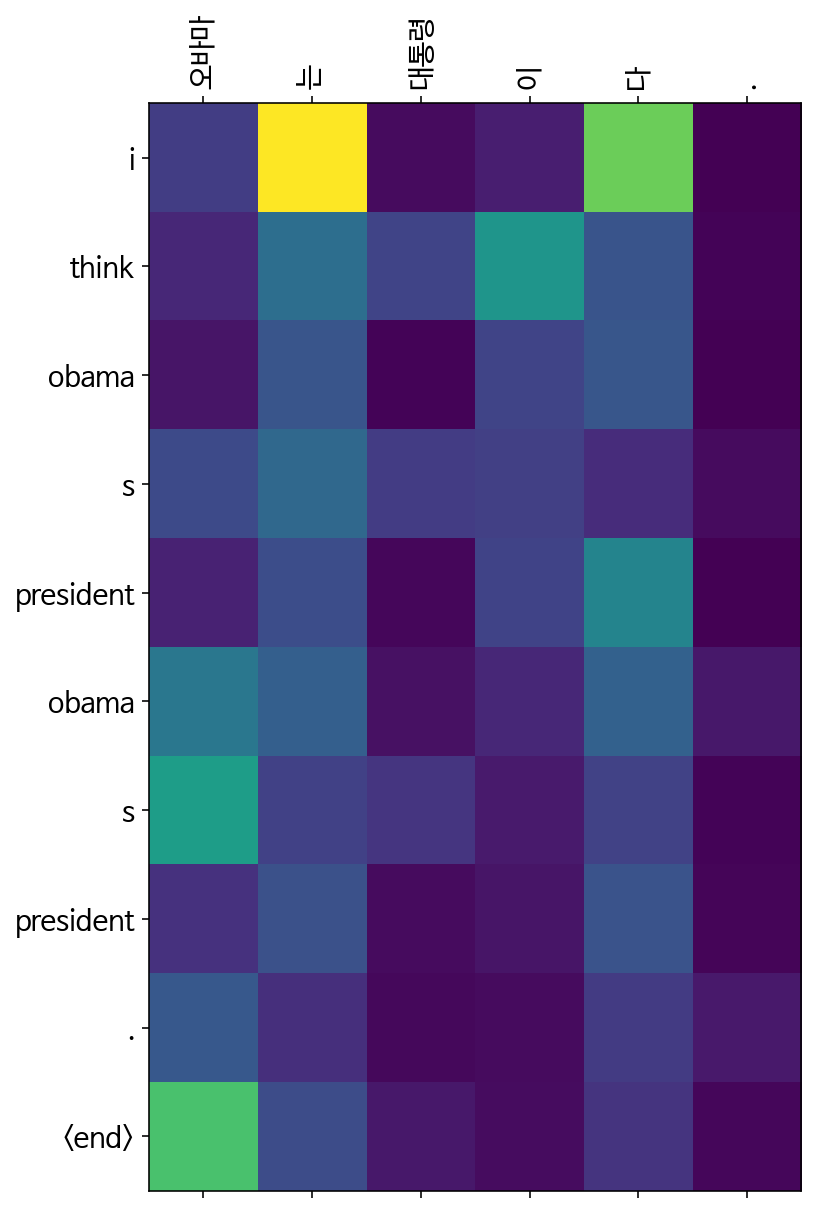

In [44]:
def evaluate(sentence, encoder, decoder):
    # 어텐션 가중치 저장
    attention = np.zeros((59, 85))
    
    # 전처리
    sentence = preprocess_sentence(sentence)
    inputs = kor_spliter.morphs(sentence)
    inputs = kor_tokenizer.texts_to_sequences([inputs])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=85,
                                                           padding='post')
    # 번역 결과를 담을 문자열 변수
    result = ''

    # 인코더
    # inputs = tf.reverse(inputs, [-1])
    enc_out = encoder(inputs)

    # 디코더
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(59):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 어텐션 가중치를 저장
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        # 디코더가 예측한 단어 디코딩
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '
        
        # 종료 토큰이 나오면 즉시 종료
        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)
    sentence = kor_spliter.morphs(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))


translate("오바마는 대통령이다.", encoder, decoder)